http://lance-modis.eosdis.nasa.gov/imagery/subsets/?mosaic=Arctic.2015152.terra.4km

In [1]:
%matplotlib inline

In [2]:
from numpy import asarray, zeros, reshape, double, arange, \
                  ma, log10, diff, mean, flipud, floor, pi, sqrt, size, fliplr, meshgrid, exp, cos, radians

In [3]:
from IPython.html import widgets
# [widget for widget in dir(widgets) if widget.endswith('Widget')]

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [4]:
import datetime

import matplotlib.pyplot as plt

from matplotlib.mlab import find

from PIL import Image

from scipy.signal import wiener

import os

__author__   = 'Alexander Myasoedov'
__email__    = 'mag@rshu.ru'
__created__  = datetime.datetime(2014, 10, 28)
__modified__ = datetime.datetime(2015, 6, 19)
__version__  = "1.0"
__status__   = "Development"

In [5]:
# Liza Polar Low 2015 June 01
inpath = '/media/SOLabNFS2/tmp/different_SAR/sentinel-1/Liza_PL_01_June_2015/'
fileNameList = ['S1A_EW_GRDM_1SDH_20150601T173700_20150601T173804_006183_0080D9_94AD.zip',
                'S1A_EW_GRDM_1SDH_20150601T173804_20150601T173858_006183_0080D9_E1A6.zip',
                'S1A_IW_GRDH_1SDV_20150601T173611_20150601T173644_006183_0080D8_B3F1.zip']

# Ania_Ladoga_29_May_2015/
inpath = '/media/SOLabNFS2/tmp/different_SAR/sentinel-1/Ania_Ladoga_29_May_2015/'
fileNameList = ['S1A_IW_GRDH_1SDV_20150603T154002_20150603T154027_006211_0081A9_5F10.zip',
                'S1A_IW_GRDH_1SDV_20150529T041657_20150529T041722_006131_007F51_F751.zip',
                'S1A_EW_GRDM_1SDH_20150517T153117_20150517T153221_005963_007AED_56B0.zip']

fn = fileNameList[0]


In [6]:
from readS1 import *
import readS1
reload(readS1)

<module 'readS1' from 'readS1.pyc'>

In [7]:
s1 = readS1.readS1(inpath=inpath, fn=fn)
# s1.__dict__['raw_counts']

Available polarizations: '[u'vv', u'vh']'
Reading raw_counts: 'vv' polarization
Interpolating LUTs: 'vv' polarization
Reading raw_counts: 'vh' polarization
Interpolating LUTs: 'vh' polarization


/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2221: DecompressionBombWarning: Image size (426079965 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [8]:
# get vars from s1 class
for k, v in s1.__dict__.iteritems():
    locals()[k]=v

In [9]:
scale = 10

sigma0w = {}
roughness = {}

print "Scale set to: \'%s\' " %scale

for p in polarization:
    print "Filtering Image: \'%s\' polarization" %p
    
    # filter the image
    sigma0w[p] = wiener(sigma0[p][::scale,::scale], mysize=(7,7), noise=None)
#     sigma0w[p] = sigma0[p]

Scale set to: '10' 
Filtering Image: 'vv' polarization
Filtering Image: 'vh' polarization


In [10]:
# S1 Pixel resolution
# we use pxlResSAR for further GSHHS rasterizing and reprojecting data with pyresample

lonlim = (lons_2[::scale,::scale].min(),lons_2[::scale,::scale].max())
latlim = (lats_2[::scale,::scale].min(),lats_2[::scale,::scale].max())

# enlarge lonlims for cropping a bit larger area for masking
lonlimGSHHS = (lonlim[0]-1.0, lonlim[1]+1.0)
latlimGSHHS = (latlim[0]-1.0, latlim[1]+1.0)


# Get first guess pixel resolution
import distancelib
pxlResSARm  = asarray(distancelib.getPixelResolution(lats_2[::scale,::scale], \
                                                     lons_2[::scale,::scale], \
                                                     lons_2[::scale,::scale].shape, 'km'))*1e3
pxlResSARdeg  = asarray(distancelib.getPixelResolution(lats_2[::scale,::scale], \
                                                       lons_2[::scale,::scale], \
                                                       lons_2[::scale,::scale].shape, 'deg'))

print "S1 cell resolution, %s deg"  % str(pxlResSARdeg)
print "S1 cell resolution, %s m"  % str(pxlResSARm)

S1 cell resolution, [ 0.00091175  0.00089511] deg
S1 cell resolution, [ 101.31405667   99.46424938] m


In [11]:
import pyresample as pr
from pyproj import Proj

# Define areas with pyresample
swath_def = pr.geometry.SwathDefinition(lons=lons_2[::scale,::scale], lats=lats_2[::scale,::scale])

area_def_4326 = swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc',
                          lonlim=lonlimGSHHS, latlim=latlimGSHHS, ellps="WGS84", res=pxlResSARm)

In [12]:
# Get the SAR pixel resolution from the area_def for further identical shapes
up    = min(latlimGSHHS)
down  = max(latlimGSHHS)
left  = min(lonlimGSHHS)
right = max(lonlimGSHHS)
area_extent_deg = (left, down, right, up)

area_extent_deg_shape = area_def_4326.shape

pxlResSARdeg = asarray( (abs(area_extent_deg[2] - area_extent_deg[0]) / float(area_extent_deg_shape[1]), \
                abs(area_extent_deg[3] - area_extent_deg[1]) / float(area_extent_deg_shape[0])) )

pxlResSARm = asarray( (area_def_4326.pixel_size_x, area_def_4326.pixel_size_y) )
print "S1 cell resolution, %s deg"  % str(pxlResSARdeg)
print "S1 cell resolution, %s m"  % str(pxlResSARm)


S1 cell resolution, [ 0.00091023  0.00089363] deg
S1 cell resolution, [ 101.32581526   99.47825155] m


In [13]:
# Apply Mask from GSHHS

import gshhs_rasterize
reload(gshhs_rasterize)

# ESRI shapefile containing land polygons
shapefile = '/media/SOLabNFS/store/auxdata/coastline/GSHHS_shp/f/GSHHS_f_L1.shp'

# reproject GSHHS onto S1 grid before calculations
print "Rasterizing Land Mask"
mask_arr_4326 = gshhs_rasterize.gshhs_rasterize_4326(lonlimGSHHS, latlimGSHHS, \
                                     pxlResSARdeg, area_def_4326.shape, True, \
                                     shapefile)

Rasterizing Land Mask


In [14]:
mask_arr_swath = pr.kd_tree.resample_nearest(area_def_4326, mask_arr_4326, swath_def, \
                                             radius_of_influence=4*pxlResSARm.max(), epsilon=0.5, fill_value=None)

In [15]:
print area_def_4326.shape, mask_arr_4326.shape
print mask_arr_swath.shape, sigma0w[p].shape, swath_def.shape

(4377, 7896) (4377, 7896)
(1665, 2560) (1665, 2560) (1665, 2560)


In [16]:
# Nice Image (Roughness)

sigma0wAvg = {}
roughnessNrmlzd = {}

if len(polarization[0])>=2: # if 2 polarizations
    for p in polarization:
        print "Nice Image: \'%s\' polarization" %p
        roughness[p] = ma.masked_where(mask_arr_swath, sigma0w[p])
        sigma0wAvg[p] = ma.median(roughness[p], axis=0)
        roughnessNrmlzd[p] = (roughness[p]-sigma0wAvg[p])/sigma0wAvg[p]
elif len(polarization[0])==1: # if only 1 polarization
    p = polarization
    print "Nice Image: \'%s\' polarization" %p
    roughness[p] = ma.masked_where(mask_arr_swath, sigma0w[p])
    sigma0wAvg[p] = ma.median(roughness[p], axis=0)
    roughnessNrmlzd[p] = (roughness[p]-sigma0wAvg[p])/sigma0wAvg[p]  

Nice Image: 'vv' polarization
Nice Image: 'vh' polarization


# Adding Model wind

In [17]:
# Adding Model wind

# import xmltodict

# zf = zipfile.ZipFile(inpath+fn, 'r')
# manifest = zf.read(fn[:-4] + '.SAFE/manifest.safe')
# manifest = xmltodict.parse(manifest) # Parse the read document string
# zf.close()

startTime = datetime.datetime.strptime(\
                              manifest['xfdu:XFDU']['metadataSection']['metadataObject'][12]\
                              ['metadataWrap']['xmlData']['safe:acquisitionPeriod']['safe:startTime'],\
                              "%Y-%m-%dT%H:%M:%S.%f")

ncepGFSmodelWind = ncepGFSmodel(startTime, lats_2, lons_2)

In [18]:
# Reprojecting data

import distancelib

# Pixel resolution
# we use pxlResWind/pxlResSAR for further pyresample radius_of_influence and sigmas
pxlResWind = asarray(distancelib.getPixelResolution(ncepGFSmodelWind['lats_wind'], \
                                                    ncepGFSmodelWind['lons_wind'], \
                                                    ncepGFSmodelWind['lons_wind'].shape, 'km'))
# pxlResSAR  = asarray(distancelib.getPixelResolution(lats_2, lons_2, lons_2.shape, 'km'))*1e3

# Note pxlResWind is in KM, multiply by 1e3 for meters
print "S1 cell resolution, %s m"  % pxlResSARm
print "Wind cell resolution, %s km" % pxlResWind

S1 cell resolution, [ 101.32581526   99.47825155] m
Wind cell resolution, [ 25.23544045  12.52520085] km


In [19]:
from scipy.interpolate import RectSphereBivariateSpline

def ncepGFSmodel2swath(lats, lons, data, lats_2, lons_2):

    func = RectSphereBivariateSpline(lats, lons, data)
    data_2 = func.ev(lats_2.ravel()*pi/180, \
                     lons_2.ravel()*pi/180)\
                     .reshape(lats_2.shape)
    return data_2


In [20]:
# reproject NCEP onto S1 grid before calculations
# Using RectSphereBivariateSpline - Bivariate spline approximation over a rectangular mesh on a sphere
# as it is much more efficiant for full resolution
# as well as smoothes nicely the image

# We don't want to work with full res wind so scaling the image for about 100m resolution
# Adjust scale to get appropriate value
scale = 10

lts = flipud(ncepGFSmodelWind['lats_wind'])[:,0]*pi/180
lns = ncepGFSmodelWind['lons_wind'][0,:]*pi/180

lts_2 = lats_2[::scale,::scale]
lns_2 = lons_2[::scale,::scale]

ncepGFSmodelWindSwath = {}
ncepGFSmodelWindSwath['wind_speed'] = ncepGFSmodel2swath(lts, lns, flipud(ncepGFSmodelWind['wind_speed']), lts_2, lns_2)
ncepGFSmodelWindSwath['wind_dir']   = ncepGFSmodel2swath(lts, lns, flipud(ncepGFSmodelWind['wind_dir']),   lts_2, lns_2)
ncepGFSmodelWindSwath['u']   = ncepGFSmodel2swath(lts, lns, flipud(ncepGFSmodelWind['u']),   lts_2, lns_2)
ncepGFSmodelWindSwath['v']   = ncepGFSmodel2swath(lts, lns, flipud(ncepGFSmodelWind['v']),   lts_2, lns_2)
    
pxlResWindSwath = asarray(distancelib.getPixelResolution(lts_2, \
                                                    lns_2, \
                                                    lns_2.shape, 'km'))

print "Interpolated Wind cell resolution, %s km" % pxlResWindSwath


Interpolated Wind cell resolution, [ 0.10131406  0.09946425] km


In [21]:
# calculate bearing from initial lats/lons for further wind calculation
# Taking initial values as bearing is more accurate after interpolation than vice versa
bearing = zeros((GEOgrid['lons'].shape[0]-1,GEOgrid['lons'].shape[1]))

for n in range(0,GEOgrid['lons'].shape[1]):
    col = ([GEOgrid['lats'][:-1,n], GEOgrid['lons'][:-1,n]], [GEOgrid['lats'][1:,n], GEOgrid['lons'][1:,n]])
    for m in range(0,GEOgrid['lons'].shape[0]-1):
        bearing[m][n] = distancelib.bearing(asarray(col[0])[:,m], asarray(col[1])[:,m])

# interpolate to raw_counts.shape
bearing_2 = imresize(bearing, ncepGFSmodelWindSwath['wind_dir'].shape)

In [22]:
def PR_Mouche(theta, phi):

    A_0 = 0.00650704
    B_0 = 0.128983
    C_0 = 0.992839
    A_HALF_PI = 0.00782194
    B_HALF_PI = 0.121405
    C_HALF_PI = 0.992839
    A_PI = 0.00598416
    B_PI = 0.140952
    C_PI = 0.992885

    P_0 = A_0 * exp(B_0* theta) + C_0
    P_HALF_PI = A_HALF_PI * exp(B_HALF_PI* theta) + C_HALF_PI
    P_PI = A_PI * exp(B_PI* theta) + C_PI
    
    C0 = (P_0 + P_PI + 2 * P_HALF_PI) / 4
    C1 = (P_0 - P_PI) / 2
    C2 = (P_0 + P_PI - 2 * P_HALF_PI) / 4
    
    P = C0 + C1 * cos(radians(phi)) + C2 * cos(radians(2 * phi))
    
    return P

In [23]:
#NB! WINDDIR = 0 WHEN WIND BLOWS TOWARDS RADAR!

p = polarization[0]

wind_dir_model_swath_rel = 90 + bearing_2 - ncepGFSmodelWindSwath['wind_dir']

if p == 'hh':
    PR = PR_Mouche(incidenceAngle_2[p][::scale,::scale], wind_dir_model_swath_rel)
    try:
        from cmod_gpu import rcs2windOpenCl
        wind_speed_asar = rcs2windOpenCl(sar=sigma0w[p]*PR, \
                                         windir=wind_dir_model_swath_rel, \
                                         theta=incidenceAngle_2[p][::scale,::scale])
    except Exception:
        from cmod_vect import rcs2windPar
        wind_speed_asar = rcs2windPar(sigma0w[p]*PR, cmdv=5, \
                                      windir=wind_dir_model_swath_rel, \
                                      theta=incidenceAngle_2[p][::scale,::scale], nprocs=numProcs)
elif p == 'vv':
    try:
        from cmod_gpu import rcs2windOpenCl
        wind_speed_asar = rcs2windOpenCl(sar=sigma0w[p], \
                                         windir=wind_dir_model_swath_rel, \
                                         theta=incidenceAngle_2[p][::scale,::scale])
    except Exception:
        from cmod_vect import rcs2windPar
        wind_speed_asar = rcs2windPar(sigma0w[p], cmdv=5, \
                                      windir=wind_dir_model_swath_rel, \
                                      theta=incidenceAngle_2[p][::scale,::scale], nprocs=numProcs)

Execution time of CMOD5 with PyOpenCl: 0.453749 s
Mean wind speed: 14.0185013871 m/s


In [24]:
# Add mask to initial NCEP data
area_def_ncep = pr.geometry.SwathDefinition(lons=ncepGFSmodelWind['lons_wind'], lats=ncepGFSmodelWind['lats_wind'])
mask_arr_ncep = pr.kd_tree.resample_nearest(area_def_4326, mask_arr_4326, area_def_ncep, \
                                             radius_of_influence=4*pxlResWind.max(), epsilon=0.5, fill_value=None)
ncepGFSmodelWind['wind_speed'] = ma.masked_where(mask_arr_ncep, ncepGFSmodelWind['wind_speed'])

# Add mask to ASAR wind and reprojected NCEP
wind_speed_asar = ma.masked_where(mask_arr_swath, wind_speed_asar)
ncepGFSmodelWindSwath['wind_speed'] = ma.masked_where(mask_arr_swath, ncepGFSmodelWindSwath['wind_speed'])

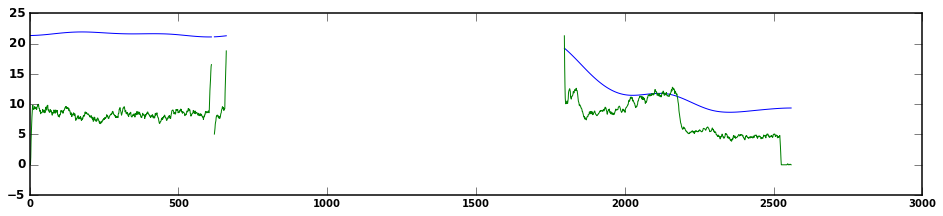

In [25]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.plot(ncepGFSmodelWindSwath['wind_speed'][600,:])
plt.plot(wind_speed_asar[600,:])

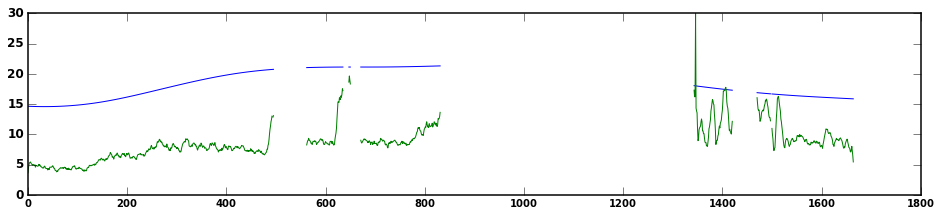

In [26]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.plot(ncepGFSmodelWindSwath['wind_speed'][:,600])
plt.plot(wind_speed_asar[:,600])

### NB! Don't forget to flipud when bearing.mean() >200
### NB! Don't forget to fliplr when bearing.mean() < 200

In [27]:
print 'bearing = %.2f' % bearing.mean()

if bearing.mean() < 200:
    wind_speed_asar = fliplr(wind_speed_asar)
    lats_2 = fliplr(lats_2)
    lons_2 = fliplr(lons_2)
    for k, v in ncepGFSmodelWindSwath.iteritems():
        ncepGFSmodelWindSwath[k] = fliplr(v)
    for k, v in roughnessNrmlzd.iteritems():
        roughnessNrmlzd[k] = fliplr(v)
    for k, v in sigma0w.iteritems():
        sigma0w[k] = fliplr(v)
elif bearing.mean() > 200:
    wind_speed_asar = flipud(wind_speed_asar)
    lats_2 = flipud(lats_2)
    lons_2 = flipud(lons_2)
    for k, v in ncepGFSmodelWindSwath.iteritems():
        ncepGFSmodelWindSwath[k] = flipud(v)
    for k, v in roughnessNrmlzd.iteritems():
        roughnessNrmlzd[k] = flipud(v)
    for k, v in sigma0w.iteritems():
        sigma0w[k] = flipud(v)
del k,v

bearing = 349.23


bearing = 349.23


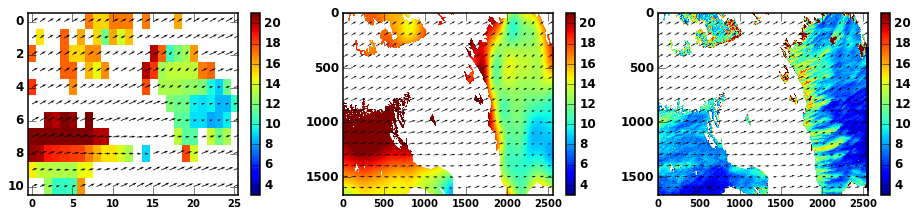

In [28]:
min_speed = 3
max_speed = 21

print 'bearing = %.2f' % bearing.mean()

plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.subplot(131)
plt.imshow(ncepGFSmodelWind['wind_speed'], vmin=min_speed, vmax=max_speed, interpolation="nearest")
plt.jet()
plt.colorbar()
plt.axis('tight')
plt.quiver(ncepGFSmodelWind['u'], ncepGFSmodelWind['v'])

X,Y = meshgrid( arange(0,roughness[p].shape[1]),arange(0,roughness[p].shape[0]) )
U = (ncepGFSmodelWindSwath['u'])
V = (ncepGFSmodelWindSwath['v'])
scl = 100

plt.subplot(132)
plt.imshow((ncepGFSmodelWindSwath['wind_speed']), vmin=min_speed, vmax=max_speed)
plt.jet()
plt.colorbar()
plt.axis('tight')
plt.quiver(X[::scl,::scl], Y[::scl,::scl], U[::scl,::scl], V[::scl,::scl])


plt.subplot(133)
plt.imshow((wind_speed_asar), vmin=min_speed, vmax=max_speed)
plt.jet()
plt.colorbar()
plt.axis('tight')
plt.quiver(X[::scl,::scl], Y[::scl,::scl], U[::scl,::scl], V[::scl,::scl])

In [29]:
print startTime, latlim, lonlim
print 'http://earth.nullschool.net/#'+startTime.strftime("%Y/%m/%d/")+'%.2d' %(ncepGFSmodelWind['baseHour'])+'00Z/wind/surface/level/orthographic=-327.02,60.84,3000'

2015-06-03 15:40:02.065109 (59.755278053867848, 61.666689289399997) (26.966562395663708, 32.153701247958111)
http://earth.nullschool.net/#2015/06/03/1200Z/wind/surface/level/orthographic=-327.02,60.84,3000


In [30]:
# %matplotlib inline

def ntrctv_imshow(p = 'hh', vmi=-1., vma=1., cmap='RdBu_r'):
    plt.figure(figsize=(16,16*double(data[p].shape[0])/double(data[p].shape[1])))
    plt.imshow((data[p]), vmin=vmi, vmax=vma)
    plt.colorbar()
    plt.set_cmap(cmap)

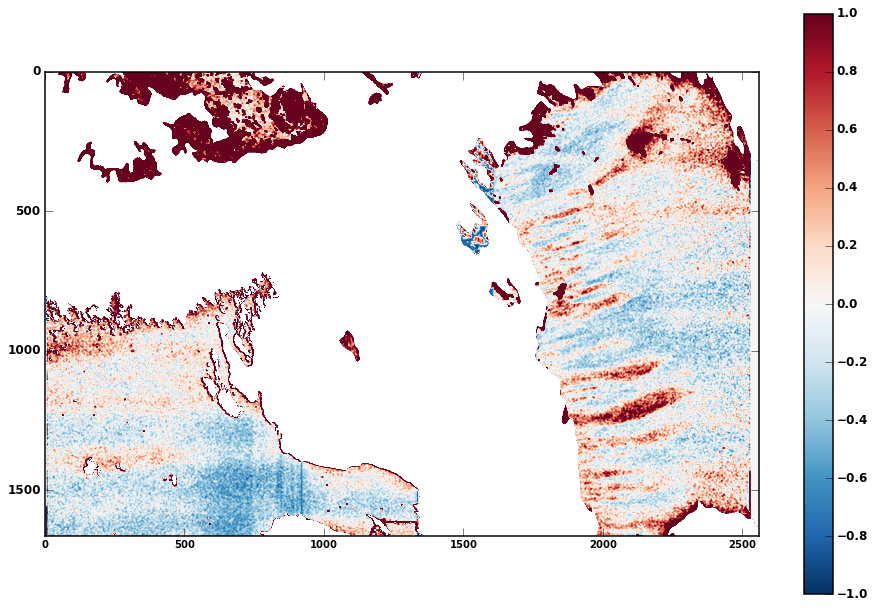

In [31]:
data=roughnessNrmlzd.copy()
# data[p] = np.where(data[p]<-1,-1,data[p])
# data[p] = np.where(data[p]>1,1,data[p])

ntrctv = widgets.interact(ntrctv_imshow, p = widgets.RadioButtons(description='polarization', options=data.keys()), \
                 vmi=widgets.FloatSliderWidget(min=-2, max=2, value=-1, step=0.1), \
                 vma=widgets.FloatSliderWidget(min=-2, max=2, value=1., step=0.1), \
                cmap = ['RdBu_r', 'Greys', 'bone']);

In [ ]:
from mpl_toolkits.basemap import Basemap
from matplotlib import cm

In [ ]:
# epsg 4326

plt.close('all')
plt.figure(figsize=(16,16*double(data[p].shape[0])/double(data[p].shape[1])))

# width=7000000.
# height=7000000.
# m = Basemap(width=width,height=height,resolution='l',\
#             projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)

# Lat/Lon coords of image corners
ll_lat = lats_2.min()
# ur_lat = lats_2.max()-4
# ll_lon = lons_2.min()-15
# ur_lon = lons_2.max()+10
ur_lat = lats_2.max()
ll_lon = lons_2.min()
ur_lon = lons_2.max()
cent_lat = lats_2.mean()
cent_lon = lons_2.mean()
m = Basemap(epsg=4326, llcrnrlat=ll_lat, urcrnrlat=ur_lat,\
            llcrnrlon=ll_lon, urcrnrlon=ur_lon, \
            resolution='i')

m.bluemarble()

x,y=m(lons_2[::scale,::scale],lats_2[::scale,::scale])
CS=m.pcolormesh(x,y,roughnessNrmlzd[polarization[0]],cmap=cm.Greys, vmin=-1, vmax=1)#,ps,cmap=cm.jet,extend='max')

m.drawmeridians(arange(round(lonlim[0]),round(lonlim[1]),1),labels=[0,0,0,1],color='y')
m.drawparallels(arange(round(latlim[0]),round(latlim[1]),1),labels=[1,0,0,0],color='y')
m.drawcoastlines(linewidth=0.5,color='0.5')
plt.title('Test')


In [ ]:
# epsg 3413

plt.close('all')
plt.figure(figsize=(16,16*double(data[p].shape[0])/double(data[p].shape[1])))
lat_ts=70.0
lat_0=90.0
lon_0=-45

# width=7000000.
# height=7000000.
# m = Basemap(width=width,height=height,resolution='l',\
#             projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)

# Lat/Lon coords of image corners
ll_lat = lats_2.min()
# ur_lat = lats_2.max()-4
# ll_lon = lons_2.min()-15
# ur_lon = lons_2.max()+10
ur_lat = lats_2.max()
ll_lon = lons_2.min()
ur_lon = lons_2.max()
cent_lat = lats_2.mean()
cent_lon = lons_2.mean()
m = Basemap(llcrnrlat=ll_lat, urcrnrlat=ur_lat,\
            llcrnrlon=ll_lon, urcrnrlon=ur_lon, \
            resolution='i', projection='stere', \
            lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)

m.bluemarble()

x,y=m(lons_2[::scale,::scale],lats_2[::scale,::scale])
CS=m.pcolormesh(x,y,roughnessNrmlzd['vv'],cmap=cm.Greys, vmin=-1, vmax=1)#,ps,cmap=cm.jet,extend='max')

m.drawmeridians(arange(lonlim[0],lonlim[1],5),labels=[0,0,0,1],color='y')
m.drawparallels(arange(0,80,5),labels=[1,0,0,0],color='y')
m.drawcoastlines(linewidth=0.5,color='0.5')
plt.title('Test')

# Saving figures for presentation

In [ ]:
# Save images for presentation
oPath = '/home/mag/tmp/for_Ania/'

for p in polarization:
    plt.close('all')
    oFileName = os.path.join(oPath, fn[:-39] + '_' + p + '_bone_r.png')
    plt.imshow(roughnessNrmlzd[p], vmin=-1, vmax=1, cmap=plt.cm.bone_r)
    plt.colorbar()
    plt.axis('tight')
    plt.savefig(oFileName, dpi=300,
                facecolor='None',
                bbox_inches='tight',
                transparent=True,
                pad_inches=0)

    plt.close('all')
    oFileName = os.path.join(oPath, fn[:-39] + '_' + p + '_RdBu_r.png')
    plt.imshow(roughnessNrmlzd[p], vmin=-1, vmax=1, cmap=plt.cm.RdBu_r)
    plt.colorbar()
    plt.axis('tight')
    plt.savefig(oFileName, dpi=300,
                facecolor='None',
                bbox_inches='tight',
                transparent=True,
                pad_inches=0)

plt.close('all')
oFileName = os.path.join(oPath, fn[:-39] + '_' + polarization[0] + '_sigma0w.png')
plt.imshow(10*log10(sigma0w[polarization[0]]), vmin=-30, vmax=-5)
plt.gray()
plt.colorbar()
plt.axis('tight')
plt.savefig(oFileName, dpi=300,
            facecolor='None',
            bbox_inches='tight',
            transparent=True,
            pad_inches=0)

plt.close('all')
oFileName = os.path.join(oPath, fn[:-39] + '_' + polarization[1] + '_sigma0w.png')
plt.imshow(10*log10(sigma0w[polarization[1]]), vmin=-35, vmax=-10)
plt.gray()
plt.colorbar()
plt.axis('tight')
plt.savefig(oFileName, dpi=300,
            facecolor='None',
            bbox_inches='tight',
            transparent=True,
            pad_inches=0)

In [ ]:
p = polarization[0]

min_speed = 0
max_speed = 9

plt.close('all')
oFileName = os.path.join(oPath, fn[:-39] + '_' + p + '_wind_ncep.png')
plt.imshow((ncepGFSmodelWind['wind_speed']), vmin=min_speed, vmax=max_speed, interpolation="nearest")
plt.jet()
plt.colorbar()
plt.axis('tight')
plt.quiver((ncepGFSmodelWind['u']), (ncepGFSmodelWind['v']))
plt.savefig(oFileName, dpi=300,
            facecolor='None',
            bbox_inches='tight',
            transparent=True,
            pad_inches=0)

X,Y = meshgrid( arange(0,roughness[p].shape[1]),arange(0,roughness[p].shape[0]) )
U = ncepGFSmodelWindSwath['u']
V = ncepGFSmodelWindSwath['v']
scl = 100

plt.close('all')
oFileName = os.path.join(oPath, fn[:-39] + '_' + p + '_wind_ncep_swath.png')
plt.imshow(ncepGFSmodelWindSwath['wind_speed'], vmin=min_speed, vmax=max_speed)
plt.jet()
plt.colorbar()
plt.axis('tight')
plt.quiver(X[::scl,::scl], Y[::scl,::scl], U[::scl,::scl], V[::scl,::scl])
plt.savefig(oFileName, dpi=300,
            facecolor='None',
            bbox_inches='tight',
            transparent=True,
            pad_inches=0)

plt.close('all')
oFileName = os.path.join(oPath, fn[:-39] + '_' + p + '_wind_S1.png')
plt.imshow(wind_speed_asar, vmin=min_speed, vmax=max_speed)
plt.jet()
plt.colorbar()
plt.axis('tight')
plt.quiver(X[::scl,::scl], Y[::scl,::scl], U[::scl,::scl], V[::scl,::scl])
plt.savefig(oFileName, dpi=300,
            facecolor='None',
            bbox_inches='tight',
            transparent=True,
            pad_inches=0)

In [ ]:
import sys
sys.getsizeof(sigma0[p])

In [ ]:
s1 = sigma0[p]

In [ ]:
import numpy as np
s1

In [ ]:
np.int16(s1).nbytes/1024/1024

In [ ]:
s1 = 0.5
np.int8(s1*127)

In [ ]:
m = roughnessNrmlzd['vv']
m = m - m.min() # Offset the image, no pixels are negative
m = 2**16*(m+m.max())/m.max() # scale
# m = m + 1
# m = 2**16*(m+1)/1
m = np.uint16(m)

In [ ]:
m.min()

In [ ]:
m.nbytes/1024/1024

In [ ]:
m.mean()

In [ ]:
m = roughnessNrmlzd['vv'][300:700,300:700]
m = np.where(m<=-1,-0.9999,m)
m = np.where(m>=1,0.9999,m)
m = m - m.min() # Offset the image, no pixels are negative # 0-2
m = 2**16*m/m.max() # scale # 65000*(m)/2
m = np.uint16(m)

plt.close('all')
plt.figure(figsize=(32,32*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.imshow(m, vmin=55*256, vmax=106*256)
plt.colorbar()

In [ ]:
m = roughnessNrmlzd['vv'][300:700,300:700]
m = np.where(m<=-1,-0.9999,m)
m = np.where(m>=1,0.9999,m)
m = m - m.min() # Offset the image, no pixels are negative # 0-2
m = 2**8*m/m.max() # scale # 65000*(m)/2
m = np.uint8(m)

plt.close('all')
plt.figure(figsize=(32,32*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.imshow(m, vmin=55, vmax=106)
plt.colorbar()

In [ ]:
plt.close('all')
plt.imshow(incidenceAngle_2[p][::scale,::scale])

In [ ]:
plt.close('all')
plt.plot(sigma0wAvg[p])
plt.plot(sigma0w[p].mean(axis=0), 'g')

In [ ]:
plt.close('all')
plt.figure(figsize=(16,12))
plt.imshow(roughness[p], vmin=0, vmax=0.01)
# plt.imshow(roughness[p], vmin=0, vmax=0.1)
plt.gray()

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16))
plt.imshow(roughnessNrmlzd[p], vmin=-1, vmax=1)
plt.set_cmap('bone_r')
# plt.set_cmap('seismic')
# plt.set_cmap('RdBu_r')


In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.subplot(121)
plt.imshow(roughness[p], vmin=0, vmax=0.1)
plt.gray()
plt.colorbar()
plt.title(p)
plt.subplot(122)
plt.imshow(roughnessNrmlzd[p], vmin=-1, vmax=1)
plt.gray()
plt.colorbar()
plt.title(p + ' Nrmlzd')

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16))
plt.imshow(roughnessNrmlzd[p], vmin=-1, vmax=1)
# plt.set_cmap('bone_r')
# plt.set_cmap('seismic')
plt.set_cmap('RdBu_r')


In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[polarization[0]].shape[0])/double(sigma0w[polarization[0]].shape[1])))
plt.subplot(131)
plt.imshow(10*log10(sigma0w[polarization[0]]), vmin=-20, vmax=5)
plt.gray()
plt.colorbar()
plt.title(polarization[0])
plt.subplot(132)
plt.imshow(10*log10(sigma0w[polarization[1]]), vmin=-30, vmax=5)
plt.gray()
plt.colorbar()
plt.title(polarization[1])
# plt.subplot(133)
# plt.imshow(roughness[polarization[0]][::scale,::scale], vmin=0, vmax=roughness[polarization[0]].mean())
# plt.gray()
# plt.colorbar()
# plt.title(polarization[0])

In [ ]:
# Adding Model wind

startTime = datetime.datetime.strptime(\
                              manifest['xfdu:XFDU']['metadataSection']['metadataObject'][12]\
                              ['metadataWrap']['xmlData']['safe:acquisitionPeriod']['safe:startTime'],\
                              "%Y-%m-%dT%H:%M:%S.%f")

ncepGFSmodelWind = ncepGFSmodel(startTime, lats_2, lons_2)

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.subplot(121)
plt.imshow(ncepGFSmodelWind['wind_speed'])
plt.jet()
plt.colorbar()
plt.subplot(122)
plt.imshow(ncepGFSmodelWind['wind_dir'])
plt.jet()
plt.colorbar()


In [ ]:
# plt.close('all')
# plt.figure(figsize=(16,4))
# plt.subplot(121)
# plt.imshow(ncepGFSmodelWind['lats_wind'])
# plt.jet()
# plt.colorbar()
# plt.subplot(122)
# plt.imshow(ncepGFSmodelWind['lons_wind'])
# plt.jet()
# plt.colorbar()

In [ ]:
# plt.close('all')
# plt.plot(ncepGFSmodelWind['lons_wind'][0,:])
# plt.plot(ncepGFSmodelWind['lats_wind'][:,0])

In [ ]:
# Reprojecting data

import distancelib

# Pixel resolution
# we use pxlResWind/pxlResSAR for further pyresample radius_of_influence and sigmas
pxlResWind = asarray(distancelib.getPixelResolution(ncepGFSmodelWind['lats_wind'], \
                                                    ncepGFSmodelWind['lons_wind'], \
                                                    ncepGFSmodelWind['lons_wind'].shape, 'km'))
# pxlResSAR  = asarray(distancelib.getPixelResolution(lats_2, lons_2, lons_2.shape, 'km'))*1e3

# Note pxlResWind is in KM, multiply by 1e3 for meters
print "S1 cell resolution, %s m"  % pxlResSARm
print "Wind cell resolution, %s km" % pxlResWind

In [ ]:
from scipy.interpolate import RectSphereBivariateSpline

def ncepGFSmodel2swath(lats, lons, data, lats_2, lons_2):

    func = RectSphereBivariateSpline(lats, lons, data)
    data_2 = func.ev(lats_2.ravel()*pi/180, \
                     lons_2.ravel()*pi/180)\
                     .reshape(lats_2.shape)
    return data_2


In [ ]:
# reproject NCEP onto S1 grid before calculations
# Using RectSphereBivariateSpline - Bivariate spline approximation over a rectangular mesh on a sphere
# as it is much more efficiant for full resolution
# as well as smoothes nicely the image

# We don't want to work with full res wind so scaling the image for about 100m resolution
# Adjust scale to get appropriate value
scale = 10

lts = flipud(ncepGFSmodelWind['lats_wind'])[:,0]*pi/180
lns = ncepGFSmodelWind['lons_wind'][0,:]*pi/180
data = flipud(ncepGFSmodelWind['wind_speed'])
data2 = flipud(ncepGFSmodelWind['wind_dir'])

lts_2 = lats_2[::scale,::scale]
lns_2 = lons_2[::scale,::scale]

wind_speed_model_swath = ncepGFSmodel2swath(lts, lns, data, lts_2, lns_2)
wind_dir_model_swath   = ncepGFSmodel2swath(lts, lns, data2, lts_2, lns_2)

del data, data2
    
pxlResWindSwath = asarray(distancelib.getPixelResolution(lts_2, \
                                                    lns_2, \
                                                    lns_2.shape, 'km'))
print "Interpolated Wind cell resolution, %s km" % pxlResWindSwath


In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[polarization[0]].shape[0])/double(sigma0w[polarization[0]].shape[1])))
plt.subplot(121)
plt.imshow(wind_speed_model_swath[::33,::33])
plt.jet()
plt.colorbar()
plt.subplot(122)
plt.imshow(wind_dir_model_swath[::33,::33])
plt.jet()
plt.colorbar()

In [ ]:
# calculate bearing from initial lats/lons for further wind calculation
# Taking initial values as bearing is more accurate after interpolation than vice versa
bearing = zeros((GEOgrid['lons'].shape[0]-1,GEOgrid['lons'].shape[1]))

for n in range(0,GEOgrid['lons'].shape[1]):
    col = ([GEOgrid['lats'][:-1,n], GEOgrid['lons'][:-1,n]], [GEOgrid['lats'][1:,n], GEOgrid['lons'][1:,n]])
    for m in range(0,GEOgrid['lons'].shape[0]-1):
        bearing[m][n] = distancelib.bearing(asarray(col[0])[:,m], asarray(col[1])[:,m])

# interpolate to raw_counts.shape
bearing_2 = imresize(bearing, wind_dir_model_swath.shape)

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.imshow(bearing_2)
plt.jet()
plt.colorbar()

In [ ]:
# # Wind Speed

# windSpeed = {}

# # the C-2PO (C-band Cross-Polarized Ocean) model
# # B. Zhang and W. Perrie, Cross-polarized synthetic aperture radar:
# # A new potential measurement technique for hurricanes, Bull. Amer. Meteor. Soc., pp. 531-541, 2012.
# if 'vh' in polarization:
#     windSpeed['vh'] = (10*log10(sigma0w['vh']) + 35.652)/0.58
# if 'hv' in polarization:
#     windSpeed['hv'] = (10*log10(sigma0w['hv']) + 35.652)/0.58

# # convert the signal measured in HH into VV polarization before using a GMF from the CMOD family
# if 'hh' in polarization:
#     alpha=1 # for Sentinel Toolbox alpha=1, initially it was 0.6
#     sigma0w['hh2vv'] = sigma0w['hh']*(1+2*tan(incidenceAngle_2['hh'])**2)**2/(1+alpha*tan(incidenceAngle_2['hh'])**2)**2

# plt.close('all')
# plt.figure(figsize=(16,16/3*double(sigma0w[polarization[0]].shape[0])/double(sigma0w[polarization[0]].shape[1])))
# plt.imshow(windSpeed['vh'][::33,::33], vmin=0, vmax=20)
# plt.jet()
# plt.colorbar()

In [ ]:
scale

In [ ]:
#NB! WINDDIR = 0 WHEN WIND BLOWS TOWARDS RADAR!
wind_dir_model_swath_rel = 90 + bearing_2 - wind_dir_model_swath
try:
    from cmod_gpu import rcs2windOpenCl
    wind_speed_asar = rcs2windOpenCl(sar=sigma0w[p], \
                                     windir=wind_dir_model_swath_rel, \
                                     theta=incidenceAngle_2[p][::scale,::scale])
except Exception:
    from cmod_vect import rcs2windPar
    wind_speed_asar = rcs2windPar(sigma0w[p], cmdv=5, \
                                  windir=wind_dir_model_swath_rel, \
                                  theta=incidenceAngle_2[p][::scale,::scale], nprocs=numProcs)

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.plot(wind_speed_model_swath[500,:])
plt.plot(wind_speed_asar[500,:])

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.plot(wind_speed_model_swath[:,1500])
plt.plot(wind_speed_asar[:,1500])

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.subplot(121)
plt.imshow(wind_speed_model_swath, vmin=3, vmax=10)
plt.jet()
plt.colorbar()
plt.subplot(122)
plt.imshow(wind_speed_asar, vmin=3, vmax=10)
plt.jet()
plt.colorbar()

In [ ]:
# Reprojecting data


roughness_4326 = pr.kd_tree.resample_nearest(swath_def, roughnessNrmlzd, area_def_4326, \
                                             radius_of_influence=4*pxlResSARm.max(), epsilon=0.5, fill_value=None)

In [ ]:
# Save png image and kml file

import simplekml

def create_KML_asar(area_extent, savepath):
    kml = simplekml.Kml()

    pol = kml.newpolygon(name='area_extent', visibility=1)
    pol.tessellate = 1

    pol.altitudemode = 'clampToGround'
    pol.outerboundaryis.coords = [(area_extent[0], area_extent[1]), (area_extent[2], area_extent[3])]
    if type(savepath) == list:
        for _savepath in savepath:
            kml.save(_savepath)
    else:
        kml.save(savepath)

oPath = '/home/mag/tmp/'
oFileName = os.path.join(oPath, fn+'.png')

close('all')
gray()
imsave(oFileName, roughness_masked, vmin=0, vmax=2)
create_KML_asar(area_def.area_extent, os.path.join(oPath, fn+'.kml'))

In [ ]:
# Generate tiles

import gdal
import sys
sys.path.append('/usr/bin')
from gdal2tiles import GDAL2Tiles

def create_asar_tiles(png_filename, tiles_output_dir, proj):
    local_argv = ['/usr/bin/gdal2tiles.py', '-p', 'raster', '-r', 'cubic',
                  '-s', proj, png_filename, tiles_output_dir]
    argv = gdal.GeneralCmdLineProcessor(local_argv)
    if argv:
        gdal2tiles = GDAL2Tiles(argv[1:])
        gdal2tiles.process()

create_KML_asar(area_def.area_extent, os.path.join(_path, fileName+'.kml'))

tiles_3413_output_dir = os.path.join(oPath, 'tiles')
png_3413_filename = oFileName
create_asar_tiles(png_3413_filename, tiles_3413_output_dir, 'EPSG:3413')

In [ ]:
# Check the lat/lon/incidenceAngle after interpolation

print diff([GEOgrid['incidenceAngle'].min(),incidenceAngle_2.min()])
print diff([GEOgrid['incidenceAngle'].max(),incidenceAngle_2.max()])

print diff([GEOgrid['lats'].min(),lats_2.min()])
print diff([GEOgrid['lats'].max(), lats_2.max()])

print diff([GEOgrid['lons'].min(), lons_2.min()])
print diff([GEOgrid['lons'].max(), lons_2.max()])

plt.close('all')
plt.figure(figsize=(16,14))

plt.subplot(321)
plt.plot(range(0,raw_counts.shape[1]), lats_2[0,:])
plt.plot(GEOgrid['pixel'][0,:], GEOgrid['lats'][0,:], 'r.')
plt.hold
plt.plot(range(0,raw_counts.shape[1]), lats_2[-1,:])
plt.plot(GEOgrid['pixel'][-1,:], GEOgrid['lats'][-1,:], 'k.')

plt.subplot(322)
plt.plot(range(0,raw_counts.shape[0]), lats_2[:,0])
plt.plot(GEOgrid['line'][:,0], GEOgrid['lats'][:,0], 'r.')
plt.hold
plt.plot(range(0,raw_counts.shape[0]), lats_2[:,-1])
plt.plot(GEOgrid['line'][:,-1], GEOgrid['lats'][:,-1], 'k.')

plt.subplot(323)
plt.plot(range(0,raw_counts.shape[1]), incidenceAngle_2[0,:])
plt.plot(GEOgrid['pixel'][0,:], GEOgrid['incidenceAngle'][0,:], 'r.')
plt.hold
plt.plot(range(0,raw_counts.shape[1]), incidenceAngle_2[-1,:])
plt.plot(GEOgrid['pixel'][-1,:], GEOgrid['incidenceAngle'][-1,:], 'k.')

plt.subplot(324)
plt.plot(range(0,raw_counts.shape[0]), incidenceAngle_2[:,0])
plt.plot(GEOgrid['line'][:,0], GEOgrid['incidenceAngle'][:,0], 'r.')
plt.hold
plt.plot(range(0,raw_counts.shape[0]), incidenceAngle_2[:,-1])
plt.plot(GEOgrid['line'][:,-1], GEOgrid['incidenceAngle'][:,-1], 'k.')

plt.subplot(325)
plt.plot(range(0,raw_counts.shape[1]), sigmaNought_2[0,:])
plt.plot(cLUTs['pixel'][0,::10], cLUTs['sigmaNought'][0,::10], 'r.')

plt.subplot(326)
plt.plot(range(0,raw_counts.shape[0]), sigmaNought_2[:,0])
plt.plot(cLUTs['line'][:,0], cLUTs['sigmaNought'][:,0], 'r.')

In [ ]:
lats_2[5465,10215], lons_2[5465,10215], incidenceAngle_2[p][5465,10215], sigma0[p][5465,10215]

In [ ]:
print arcsin((4.740000e+02/6.666194e+02)**2)*180/pi, incidenceAngle_2[p][0,0]
print arcsin((4.740000e+02/5.596816e+02)**2)*180/pi, incidenceAngle_2[p][-1,-1]

In [ ]:
from osgeo import gdal

ds = gdal.Open(inpath + fileLocation['s1aiwgrd' + polarization])
ds.RasterCount

In [ ]:
ds = gdal.Open('/media/data/data/OTHER/RS2 Agulhas and Lion/RS2_SQA_1xQGSS20091224_164846_00000004/imagery_HV.tif')
ds.RasterCount

In [ ]:
ds = gdal.Open('/media/SOLabNFS2/tmp/sentinel-1/S1A_IW_SLC__1SDV_20141003T151001_20141003T151028_002667_002F87_7088.SAFE/measurement/s1a-iw1-slc-vv-20141003t151002-20141003t151027-002667-002f87-004.tiff')
slc = ds.ReadAsArray()
slc.dtype
del slc

In [ ]:
# ----------------------------------
# from scipy.interpolate import griddata
# from numpy import meshgrid, linspace

# Slant Range, Single-Look Complex (SLC) products
# are images in the slant range by azimuth imaging plane,
# in the image plane of satellite data acquisition.
# THAT MEANS that they must be interpolated more carefully using slantRangeTime and azimuthTime as in ASAR

# create new grid of raw_counts shape
# line_2, pixel_2 = meshgrid(linspace(0, lats.shape[0], raw_counts.shape[0]), linspace(0, lats.shape[1], raw_counts.shape[1]))
# Interpolate onto a new grid
# lats_2 = griddata((line.ravel(), pixel.ravel()), lats.ravel(), (line_2, pixel_2), method='cubic')
# lons_2 = griddata((line.ravel(), pixel.ravel()), lons.ravel(), (line_2, pixel_2), method='cubic')


In [ ]:
#     # Nice Image (Roughness)
#     if p == 'hh':
#         ph = (2.20495, -14.3561e-2, 11.28e-4)
#         sigma0_hh_ref = exp( ( ph[0]+incidenceAngle_2[p]*ph[1]+incidenceAngle_2[p]**2*ph[2])*log(10) )
#         roughness[p] = sigma0w[p]/sigma0_hh_ref
#     elif p == 'vv':
#         pv = (2.29373, -15.393e-2, 15.1762e-4)
#         sigma0_vv_ref = exp( ( pv[0]+incidenceAngle_2[p]*pv[1]+incidenceAngle_2[p]**2*pv[2])*log(10) )
#         roughness[p] = sigma0w[p]/sigma0_vv_ref